In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

#Обработка данных

In [125]:
def load_db(db_file):
  with sqlite3.connect(db_file) as conn:
    tables = list(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)['name'])
    db = {table : pd.read_sql_query(f"SELECT * from {table}", conn) for table in tables}
  return db

In [126]:
db_sales = load_db("sales.db")

In [127]:
db_sales['sales'].sample(5)

,DocDate,StockNum,GoodNum,Quant,Price
29450,2020-04-01,14,6,10,192.09
29658,2020-12-01,4,24,1,114.49
17361,2020-11-01,3,118,2,126.85
17970,2020-02-01,0,63,4,87.99
30043,2020-06-01,2,11,83,100.78


In [128]:
db_sales['sales'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32402 entries, 0 to 32401
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DocDate   32402 non-null  object 
 1   StockNum  32402 non-null  int64  
 2   GoodNum   32402 non-null  int64  
 3   Quant     32402 non-null  int64  
 4   Price     32402 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.2+ MB


In [129]:
db_sales['goods'].sample(5)

,GoodNum,GoodDesc,ProductCatNum
103,103,Гиоксизон мазь туба 10г,5
59,59,Корвалол фл.25мл,6
106,106,Ксимелин Экстра спрей 84мкг/доза+70мкг 10мл,3
28,28,Омепразол (Омез)-Тева капс. 20мг №28,0
141,141,Нурофен Лонг таб.п.пл/об.200мг+500мг №6,2


In [130]:
db_sales['goods'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   GoodNum        198 non-null    int64 
 1   GoodDesc       198 non-null    object
 2   ProductCatNum  198 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ KB


In [131]:
len(db_sales['goods']['GoodDesc'].unique())

198

In [132]:
db_sales['stocks']

,StockNum,StockDesc
0,0,ЖелДор2
1,1,Королев2
2,2,Одинцово
3,3,Новокузьминская
4,4,Раменки
5,5,Одинцово2
6,6,Крымская
7,7,Московский
8,8,Новогиреево
9,9,Новокосино3


In [133]:
db_sales['categs']

,ProductCatNum,ProductCatDesc
0,0,ОМЕПРАЗОЛ
1,1,Сосудосуживающие для взрослых спрей
2,2,Анальгетики Бренды
3,3,Насморк лечение КСИЛОМЕТАЗОЛИН спрей
4,4,Антисептические средства Хлоргексидин
5,5,Противомикробные наружные средства
6,6,"Седативные, настойки/капли"
7,7,Контейнер для анализов
8,8,Гематогены/мюсли
9,9,Пластыри бактерицидные


#Аналитика

In [134]:
db_sales['sales'].sample(5)

,DocDate,StockNum,GoodNum,Quant,Price
4241,2019-06-01,10,88,14,84.28
1893,2019-03-01,0,30,42,23.66
2964,2019-04-01,11,99,2,168.59
16325,2019-11-01,13,170,1,447.49
11823,2019-09-01,6,164,5,48.25


Рассчитайте общие продажи (выручку) по каждому продукту и категории за весь период.

1. Общие продажи (выручку) по каждому **продукту**


In [135]:
db_sales_total_price = db_sales['sales'].copy()
db_sales_total_price['TotalPrice'] = db_sales_total_price.apply(lambda x: x['Quant'] * x['Price'], axis=1)

goods_incomes = db_sales_total_price \
  .groupby('GoodNum', as_index=False) \
  .agg(Income=('TotalPrice', 'sum')) \
  .merge(db_sales['goods'][['GoodNum', 'GoodDesc']], how='left', on='GoodNum')
goods_incomes[['GoodDesc', 'Income']]

,GoodDesc,Income
0,Омез капс. 20мг №30,3039676.95
1,Ринофлуимуцил спрей 10мл,1967576.24
2,Нурофен супп. 60мг №10 (д/детей),25530.44
3,"Отривин спрей 0,05% 10мл",154195.98
4,"Хлоргексидина биглюконат фл. 0,05% 100мл (плас...",1267767.58
...,...,...
193,Леденец 12 витаминов Вариант (14г) 14г,9826.74
194,"Бат. ""Капитан Сильвер"" 50г (кокос+какао+шок. г...",91.12
195,"Хлоргексидина биглюконат фл. 0,05% 100мл (пласт.)",9265.99
196,"Хлоргексидин тюб.-кап.0,05% 10 мл №10",77.47


2. Общие продажи (выручку) по каждой **категории**


In [136]:
cats_incomes = db_sales_total_price \
  .merge(db_sales['goods'][['GoodNum', 'ProductCatNum']], how='left', on='GoodNum') \
  .groupby('ProductCatNum', as_index=False) \
  .agg(Income=('TotalPrice', 'sum')) \
  .merge(db_sales['categs'][['ProductCatNum', 'ProductCatDesc']])
cats_incomes[['ProductCatDesc', 'Income']]

,ProductCatDesc,Income
0,ОМЕПРАЗОЛ,5736218.91
1,Сосудосуживающие для взрослых спрей,7440556.81
2,Анальгетики Бренды,14041282.89
3,Насморк лечение КСИЛОМЕТАЗОЛИН спрей,12922641.81
4,Антисептические средства Хлоргексидин,1784708.29
5,Противомикробные наружные средства,5358741.63
6,"Седативные, настойки/капли",5039280.22
7,Контейнер для анализов,1155384.50
8,Гематогены/мюсли,2335655.40
9,Пластыри бактерицидные,1252714.42


In [137]:
with pd.ExcelWriter('task1.xlsx', engine='openpyxl') as writer:
  goods_incomes[['GoodDesc', 'Income']].rename(
    columns={'GoodDesc':"Название продукта", 'Income':'Выручка'})\
    .to_excel(writer, sheet_name='Продажи по продуктам', index=False)

  cats_incomes[['ProductCatDesc', 'Income']].rename(
    columns={'ProductCatDesc':"Название категории", 'Income':'Выручка'})\
    .to_excel(writer, sheet_name='Продажи по категориям', index=False)

Определите топ-5 продуктов, категорий и аптек по выручке за последний год.

1. Топ-5 продуктов по выручке за последний год.

In [138]:
last_year = pd.to_datetime(
              db_sales_total_price\
              .sort_values('DocDate', ascending=False)['DocDate']\
              .max()
            ).year
last_year

2020

In [139]:
db_sales_total_price_last_year = db_sales['sales'][pd.to_datetime(db_sales['sales']['DocDate']).dt.year == last_year].copy()
db_sales_total_price_last_year['TotalPrice'] = db_sales_total_price_last_year.apply(lambda x: x['Quant'] * x['Price'], axis=1)

goods_incomes_last_year = db_sales_total_price_last_year \
  .groupby('GoodNum', as_index=False) \
  .agg(Income=('TotalPrice', 'sum')) \
  .merge(db_sales['goods'][['GoodNum', 'GoodDesc']], how='left', on='GoodNum')

xl_goods_incomes = goods_incomes_last_year[['GoodDesc', 'Income']]\
  .sort_values('Income', ascending=False)\
  .head(5)
xl_goods_incomes['Место в топе'] = np.arange(1, len(xl_goods_incomes)+1)
xl_goods_incomes = (
  xl_goods_incomes
    .rename(
      columns={
          'GoodDesc':'Название продукта',
          'Income':'Выручка'
      }
    )
  )
xl_goods_incomes = xl_goods_incomes[['Место в топе', 'Название продукта', 'Выручка']]
xl_goods_incomes

,Место в топе,Название продукта,Выручка
45,1,Пенталгин таб. №24,2124557.84
69,2,Нурофен Экспресс капс. 200мг №16,1506068.67
10,3,"Снуп спрей 0,1% 15мл",1433484.38
0,4,Омез капс. 20мг №30,1416882.39
85,5,"Тизин Классик спрей 0,1% 10мл",1129848.86


2. Топ-5 категорий по выручке за последний год.

In [140]:
 cats_incomes_last_year = db_sales_total_price_last_year \
  .merge(db_sales['goods'][['GoodNum', 'ProductCatNum']], how='left', on='GoodNum') \
  .groupby('ProductCatNum', as_index=False) \
  .agg(Income=('TotalPrice', 'sum')) \
  .merge(db_sales['categs'][['ProductCatNum', 'ProductCatDesc']])

xl_cats_incomes = cats_incomes_last_year[['ProductCatDesc', 'Income']]\
  .sort_values('Income', ascending=False)\
  .head(5)
xl_cats_incomes['Место в топе'] = np.arange(1, len(xl_cats_incomes)+1)
xl_cats_incomes = (
  xl_cats_incomes
  .rename(
    columns={
        'ProductCatDesc':"Название категории",
        'Income':'Выручка'
    }
  )
)
xl_cats_incomes = xl_cats_incomes[['Место в топе', 'Название категории', 'Выручка']]
xl_cats_incomes

,Место в топе,Название категории,Выручка
2,1,Анальгетики Бренды,7150213.22
3,2,Насморк лечение КСИЛОМЕТАЗОЛИН спрей,6252466.56
1,3,Сосудосуживающие для взрослых спрей,4005086.96
6,4,"Седативные, настойки/капли",2862507.17
0,5,ОМЕПРАЗОЛ,2784873.73


3. Топ-5 аптек по выручке за последний год.

In [141]:
stocks_incomes_last_year = db_sales_total_price_last_year \
  .groupby('StockNum', as_index=False) \
  .agg(Income=('TotalPrice', 'sum')) \
  .merge(db_sales['stocks'][['StockNum', 'StockDesc']])

xl_stock_incomes = stocks_incomes_last_year[['StockDesc', 'Income']] \
  .sort_values('Income', ascending=False) \
  .head(5)
xl_stock_incomes['Место в топе'] = np.arange(1, len(xl_stock_incomes)+1)
xl_stock_incomes = (
    xl_stock_incomes
      .rename(
        columns={
            'StockDesc':'Название аптеки',
            'Income':'Выручка'
        }
      )
    )
xl_stock_incomes = xl_stock_incomes[['Место в топе', 'Название аптеки', 'Выручка']]
xl_stock_incomes

,Место в топе,Название аптеки,Выручка
14,1,Люберцы,3132847.01
5,2,Одинцово2,2371830.43
7,3,Московский,2290062.51
8,4,Новогиреево,2248701.96
13,5,Жуковский,2111627.62


In [142]:
from openpyxl import load_workbook

book = load_workbook('task1.xlsx')

with pd.ExcelWriter(
    'task1.xlsx',
    engine='openpyxl',
    mode='a',
    if_sheet_exists='replace'
) as writer:
  writer._book = book

  xl_goods_incomes\
    .to_excel(writer, sheet_name='Топ-5 продуктов по выручке за последний год', index=False)

  xl_cats_incomes\
    .to_excel(writer, sheet_name='Топ-5 категорий по выручке за последний год', index=False)

  xl_stock_incomes\
    .to_excel(writer, sheet_name='Топ-5 аптек по выручке за последний год', index=False)

/usr/local/lib/python3.11/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [143]:
with sqlite3.connect('sales.db') as conn:
  query = """
  with last_year as (
    SELECT strftime('%Y', MAX(date(DocDate))) FROM sales LIMIT 1
  )

  SELECT
    g.GoodDesc,
    SUM(Quant * Price) as Income
  FROM sales AS s
    JOIN goods AS g USING(GoodNum)
  WHERE strftime('%Y', date(DocDate)) in last_year
  GROUP BY g.GoodNum
  ORDER BY  Income DESC
  LIMIT 5
  """
  response = pd.read_sql(query, conn)
  print(response)

                           GoodDesc      Income
0                Пенталгин таб. №24  2124557.84
1  Нурофен Экспресс капс. 200мг №16  1506068.67
2              Снуп спрей 0,1% 15мл  1433484.38
3               Омез капс. 20мг №30  1416882.39
4     Тизин Классик спрей 0,1% 10мл  1129848.86


In [144]:
with sqlite3.connect('sales.db') as conn:
  query = """
  with last_year as (
    SELECT strftime('%Y', MAX(date(DocDate))) FROM sales LIMIT 1
  )

  SELECT
    c.ProductCatDesc,
    SUM(Quant * Price) as Income
  FROM sales AS s
    JOIN goods AS g USING(GoodNum)
      JOIN categs AS c USING(ProductCatNum)
  WHERE strftime('%Y', date(DocDate)) in last_year
  GROUP BY c.ProductCatDesc
  ORDER BY Income DESC
  LIMIT 5
  """
  response = pd.read_sql(query, conn)
  print(response)

                         ProductCatDesc      Income
0                    Анальгетики Бренды  7150213.22
1  Насморк лечение КСИЛОМЕТАЗОЛИН спрей  6252466.56
2   Сосудосуживающие для взрослых спрей  4005086.96
3            Седативные, настойки/капли  2862507.17
4                             ОМЕПРАЗОЛ  2784873.73


In [145]:
with sqlite3.connect('sales.db') as conn:
  query = """
  with last_year as (
    SELECT strftime('%Y', MAX(date(DocDate))) FROM sales LIMIT 1
  )

  SELECT
    StockDesc,
    SUM(Quant * Price) as Income
  FROM sales AS s
    JOIN stocks AS st USING(StockNum)
  WHERE strftime('%Y', date(DocDate)) in last_year
  GROUP BY StockDesc
  ORDER BY Income DESC
  LIMIT 5
  """
  response = pd.read_sql(query, conn)
  print(response)

     StockDesc      Income
0      Люберцы  3132847.01
1    Одинцово2  2371830.43
2   Московский  2290062.51
3  Новогиреево  2248701.96
4    Жуковский  2111627.62


#Визуализация

Постройте график динамики продаж по месяцам для топ-3 категорий.

In [146]:
cats_incomes = db_sales_total_price \
  .merge(db_sales['goods'][['GoodNum', 'ProductCatNum']], how='left', on='GoodNum') \
  .groupby('ProductCatNum', as_index=False) \
  .agg(Income=('TotalPrice', 'sum')) \
  .merge(db_sales['categs'][['ProductCatNum', 'ProductCatDesc']])

top_3_cats = cats_incomes[['ProductCatNum', 'Income']]\
  .sort_values('Income', ascending=False)\
  .head(3)\
  .ProductCatNum\
  .values

top_3_cats_incomes_per_months = db_sales_total_price \
  .merge(db_sales['goods'][['GoodNum', 'ProductCatNum']], how='left', on='GoodNum') \
  .query('ProductCatNum in @top_3_cats')\
  .merge(db_sales['categs'][['ProductCatNum', 'ProductCatDesc']], how='right', on='ProductCatNum')\
  .groupby(['DocDate', 'ProductCatDesc'], as_index=False) \
  .agg(Income=('TotalPrice', 'sum'))

top_3_cats_incomes_per_months = (
  top_3_cats_incomes_per_months
  .rename(
    columns={
      'Income':'Выручка',
      'DocDate':'Дата'
    }
  )
)

top_3_cats_incomes_per_months['Дата'] = (
  top_3_cats_incomes_per_months['Дата'].apply(lambda x: x[:7])
)

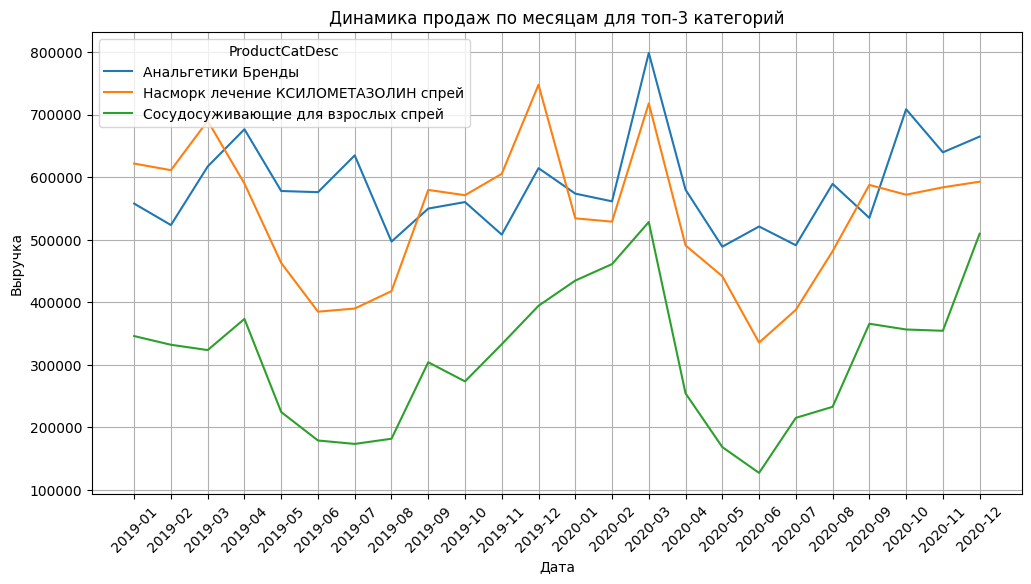

<Figure size 640x480 with 0 Axes>

In [147]:
plt.figure(figsize=(12, 6))
plt.title("Динамика продаж по месяцам для топ-3 категорий")
plt.xticks(rotation=45)
plt.grid(True)
sns.lineplot(data=top_3_cats_incomes_per_months, x='Дата', y='Выручка', hue='ProductCatDesc')
plt.show()
plt.savefig("Динамика продаж по месяцам для топ-3 категорий.png")

In [148]:
cats_incomes_per_months = (
  db_sales_total_price
  .merge(db_sales['goods'][['GoodNum', 'ProductCatNum']], how='left', on='GoodNum')
  .merge(db_sales['categs'][['ProductCatNum', 'ProductCatDesc']], how='right', on='ProductCatNum')
  .groupby(['ProductCatDesc'], as_index=False)
  .agg(Income=('TotalPrice', 'sum'))
  .sort_values('Income')
  .rename(
    columns={
      'ProductCatDesc':"Название категории",
      'Income':'Выручка'}
  )
)

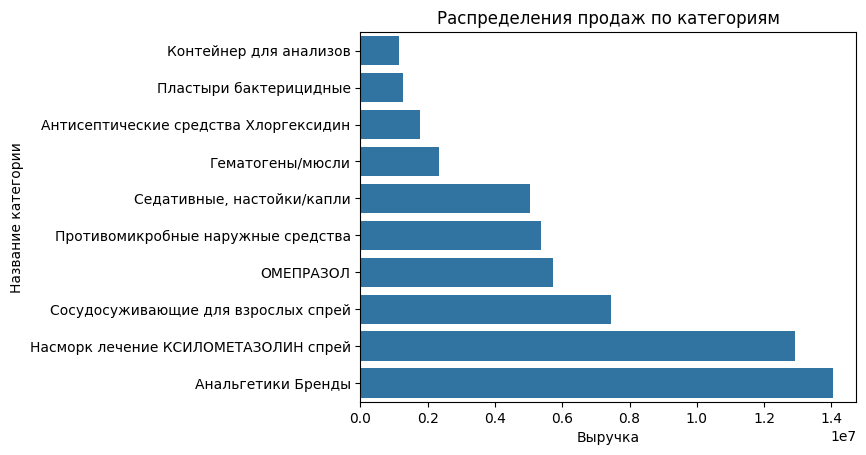

In [149]:
plt.title("Распределения продаж по категориям")
sns.barplot(cats_incomes_per_months, y='Название категории', x='Выручка');
plt.savefig("Распределения продаж по категориям.png")

#Дополнительные задания

Определите топ-3 продуктов в каждой категории

In [150]:
with sqlite3.connect('sales.db') as conn:
  query = """
  WITH RankedSales as (
    SELECT
      ProductCatDesc,
      GoodDesc,
      SUM(Quant * Price) as Income,
      ROW_NUMBER() OVER (PARTITION BY ProductCatDesc ORDER BY SUM(s.Quant * s.Price) DESC) as IncomeRank
    FROM sales AS s
      JOIN goods AS g USING(GoodNum)
        JOIN categs as c USING(ProductCatNum)
    GROUP BY ProductCatNum, GoodDesc
  )

  SELECT
    IncomeRank,
    ProductCatDesc,
    GoodDesc,
    Income
  FROM RankedSales
  WHERE IncomeRank <= 3
  ORDER BY ProductCatDesc, IncomeRank
  """
  df = pd.read_sql(query, conn)
  print(df)
  book = load_workbook('task1.xlsx')

  with pd.ExcelWriter(
      'task1.xlsx',
      engine='openpyxl',
      mode='a',
      if_sheet_exists='replace'
  ) as writer:
    writer._book = book

    df.rename(
      columns={
        'IncomeRank': 'Место в топе',
        'ProductCatDesc':"Название категории",
        'Income':'Выручка'}
      )\
    .to_excel(
      writer,
      sheet_name='Топ-3 продуктов в каждой категории',
      index=False
    )

    IncomeRank                         ProductCatDesc  \
0            1                     Анальгетики Бренды   
1            2                     Анальгетики Бренды   
2            3                     Анальгетики Бренды   
3            1  Антисептические средства Хлоргексидин   
4            2  Антисептические средства Хлоргексидин   
5            3  Антисептические средства Хлоргексидин   
6            1                       Гематогены/мюсли   
7            2                       Гематогены/мюсли   
8            3                       Гематогены/мюсли   
9            1                 Контейнер для анализов   
10           2                 Контейнер для анализов   
11           3                 Контейнер для анализов   
12           1   Насморк лечение КСИЛОМЕТАЗОЛИН спрей   
13           2   Насморк лечение КСИЛОМЕТАЗОЛИН спрей   
14           3   Насморк лечение КСИЛОМЕТАЗОЛИН спрей   
15           1                              ОМЕПРАЗОЛ   
16           2                 

/usr/local/lib/python3.11/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


#Выводы
* Категория "Насморк лечение КСИЛОМЕТАЗОЛИН спрей" демонстрирует выраженную
сезонность, с пиками продаж в холодные месяцы (октябрь-март). Это связано с увеличением случаев простудных заболеваний в этот период.

* Категория "Сосудосуживающие для взрослых спрей" имеет схожую тенденцию с категорией "Насморк лечение КСИЛОМЕТАЗОЛИН спрей", но имеет меньшую выручку.

* Категория "Анальгетики Бренды" имеет более стабильные продажи в течение года, что характерно для обезболивающих препаратов, спрос на которые не зависит от времени года.

* Лидирующие позиции продажи занимают анальгетики ("Пенталгин" - 1ое место, "Нурофен" - 2ое место по продажам). В топе продаж также есть средства от насморка ("Снуп спрей" - 3e место, "Тизин Классик спрей" - 5ое место) и средство для личения язв желудка "Омез" - 4ое место в топе самых продаваемы продуктов.

Возможные направления для увеличения продаж:
* увеличение рекламных кампаний в начале сезона спроса для сезонных продуктов
* стимулирование роста продаж для анальгетиков посредством внедрения акций или программ лояльности.